# Iterative Closest Point

<img src="i/icp1.png" width=600>
<br>
<img src="i/icp2.png" width=600>
<br>

<img src="i/icp3.png" width=600>
<br>
<img src="i/icp4.png" width=600>


In [12]:
# generate 2 lidar scans (i.e. 2 point clouds A, B)
import numpy as np 
import matplotlib.pyplot as plt 
np.random.seed(1)

def generate_point_cloud(n=3, N=30):
    points = np.random.randn(n, N)
    return points 
A = generate_point_cloud()

def rigid_transform(A, rotate_by=5, t=[0.1, 0.1, 0.4], noise_var=0.01):
    n, _ = A.shape 
    theta = np.deg2rad(rotate_by)
    
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]])
    
    t = np.array(t)
    B = R @ A + t.reshape(n, 1)
    
    noise = np.random.normal(loc=0, scale=noise_var, size=B.shape)
    B = B + noise 
    return B, R, t 

B, R, t = rigid_transform(A)
print(R)
print(B.shape)
print(t)

[[ 0.9961947  -0.08715574  0.        ]
 [ 0.08715574  0.9961947   0.        ]
 [ 0.          0.          1.        ]]
(3, 30)
[0.1 0.1 0.4]


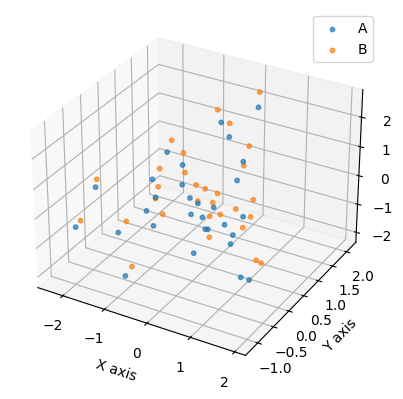

[[ 0.9961947  -0.08715574  0.        ]
 [ 0.08715574  0.9961947   0.        ]
 [ 0.          0.          1.        ]]
[0.1 0.1 0.4]


In [22]:
def plot_clouds(A, B, A_hat=None, point_size=5):
    xa, ya, za = A[0, :], A[1, :], A[2, :]
    xb, yb, zb = B[0, :], B[1, :], B[2, :]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xa, ya, za, s=point_size, alpha=0.7, label='A')
    ax.scatter(xb, yb, zb, s=point_size, alpha=0.7, label='B')

    if A_hat is not None:
        xc, yc, zc = A_hat[0, :], A_hat[1, :], A_hat[2, :]
        ax.scatter(xc, yc, zc, s=point_size, alpha=0.9, label='A_hat')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.legend()
    plt.show()

plot_clouds(A, B, point_size=10)
print(R)
print(t)